In [9]:
import numpy as np 
import pandas as pd
import calendar
from time import strptime
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, min, max
from statsmodels.tsa.stattools import acf, pacf
from pyspark.ml.feature import StringIndexer
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

pd.set_option("display.max_columns", None)

spark = SparkSession \
       .builder \
       .appName("Rain Forecase") \
       .config("spark.executor.heartbeatInterval","60s")\
       .getOrCreate()

rdd = spark.read.format("csv").option("header", "true").load("/Users/rajeevkumar/Downloads/Coursera/rainfall in india 1901-2015.csv")
rdd.createOrReplaceTempView("rainfall")

#get all the rows which does not have zero value for rain in any month
annualrain = spark.sql("select *  from rainfall where JAN <> 0 and FEB <> 0 and MAR <> 0 and APR <> 0 and MAY <> 0 and JUN <> 0 and JUL <> 0 and AUG <> 0 \
                       and SEP <> 0 and OCT <> 0 and NOV <> 0 and DEC <> 0 and SUBDIVISION = 'ANDAMAN & NICOBAR ISLANDS' and YEAR > 1910")

#Convert the datatype of each selected columns
annualrain1 = annualrain.selectExpr("cast(YEAR as int) YEAR", "cast(JAN as float) JAN", "cast(FEB as float) FEB", "cast(MAR as float) MAR", "cast(APR as float) APR", "cast(MAY as float) MAY" \
                                    , "cast(JUN as float) JUN", "cast(JUL as float) JUL", "cast(AUG as float) AUG", "cast(SEP as float) SEP", "cast(OCT as float) OCT" \
                                    , "cast(NOV as float) NOV",  "cast(DEC as float) DEC")

#Convert into Pandas
annualrain1 = annualrain1.toPandas()

indexed =  StringIndexer().setInputCol("SUBDIVISION").setOutputCol("subDvn") 
indexed = indexed.fit(annualrain).setHandleInvalid("skip").transform(annualrain)
indexed1 = indexed.drop('SUBDIVISION')
indexed1 = indexed1.dropna()

In [10]:
#Put all the columns other than YEAR into rows
annualrain2 = pd.melt(annualrain1, id_vars=['YEAR'], var_name="Month", value_name=('RainMM'))

#Convert Month name "MMM" into month number (1,2,3...)
annualrain2.Month = annualrain2.Month.apply(lambda x: strptime(x,'%b').tm_mon)

#Create a another column by combinning YEAR and Month column and putting a default day as 1
annualrain3 = annualrain2.assign(Date=pd.to_datetime(annualrain2[['YEAR', 'Month']].assign(day=1)))

#Change the datatype to time
annualrain3['Date'] = pd.to_datetime(annualrain3['Date'],infer_datetime_format=True)


annualrain4 = annualrain3.drop(columns=['Month','YEAR'])

cols = annualrain4.columns.tolist()
cols = cols[-1:] + cols[:-1]

#Change column positions
annualrain4 = annualrain4[cols]
annualrain5 = annualrain4.sort_values('Date') 
annualrain5 = annualrain5.reset_index(drop=True)

#Forward fill for na data
annualrain5.fillna(method='ffill', inplace=True)

#ts = annualrain4.set_index(['Date'])
#Since Data is not available for all months, create a dataframe for Rains and drop na rows
ts = annualrain5['RainMM']/10
ts.dropna(inplace=True)
ts.head()

0     4.50
1     5.67
2     3.33
3     4.09
4    17.02
Name: RainMM, dtype: float32

In [14]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    fig1=plt.gcf()
    plt.show()
    fig1.savefig('Rolling Mean and Standard Deviation.png', dpi=200)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, regression='c',autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value %s : '%key] = '{0:.5f}'.format(value)
    print(dfoutput)

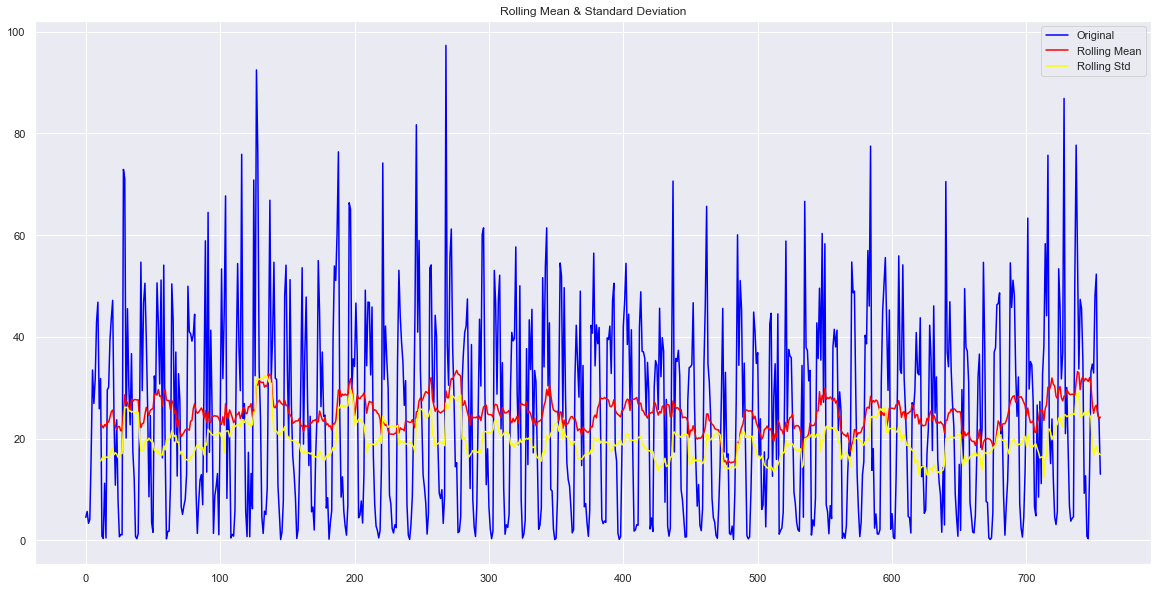

Results of Dickey-Fuller Test:
Test Statistic                    -6.15417
p-value                        7.43743e-08
#Lags Used                              18
Number of Observations Used            737
Critical Value 1% :               -3.43925
Critical Value 5% :               -2.86547
Critical Value 10% :              -2.56886
dtype: object


In [15]:
test_stationarity(ts)

Now, let try to decompose the time series data using season_deccompose algorithm. In season decompose, the model value is either additive or multiplicative. 
The additive model is Y[t] = T[t] + S[t] + e[t]
The multiplicative model is Y[t] = T[t] * S[t] * e[t]

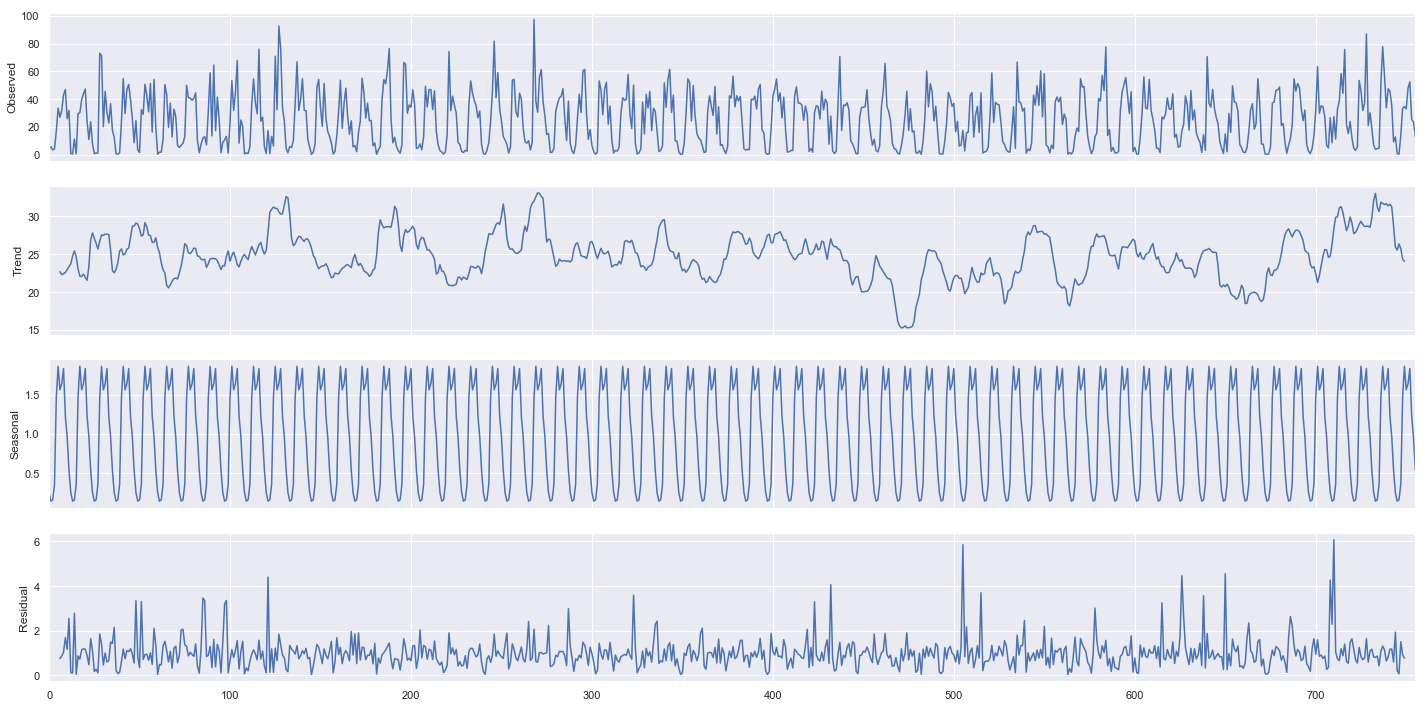

In [16]:
import seaborn as sns; sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose

#check datatype of index
decomposition = seasonal_decompose(ts, model='multiplicative', freq = 12)
residual = decomposition.resid
seasonal = decomposition.seasonal 
trend = decomposition.trend
fig = decomposition.plot()  
fig1=plt.gcf()
plt.show()
fig1.savefig('seasonal_decompose.png', dpi=100)

In [17]:
num_of_rows = int((ts.shape[0]) * 0.8)
train = ts.iloc[:num_of_rows] #indexes rows for training data
test = ts.iloc[num_of_rows:] #indexes rows for test data

train_log = np.log(train)
train_log.dropna(inplace=True)

test_log = np.log(test)
test_log.dropna(inplace=True)


#trainRollingMean = (train - train.rolling(window=12).mean()) / train.rolling(window=12).std()
#trainRollingMeanWithShift = trainRollingMean - trainRollingMean.shift(15)
#trainRollingMeanWithShift.dropna(inplace=True)
#train_log

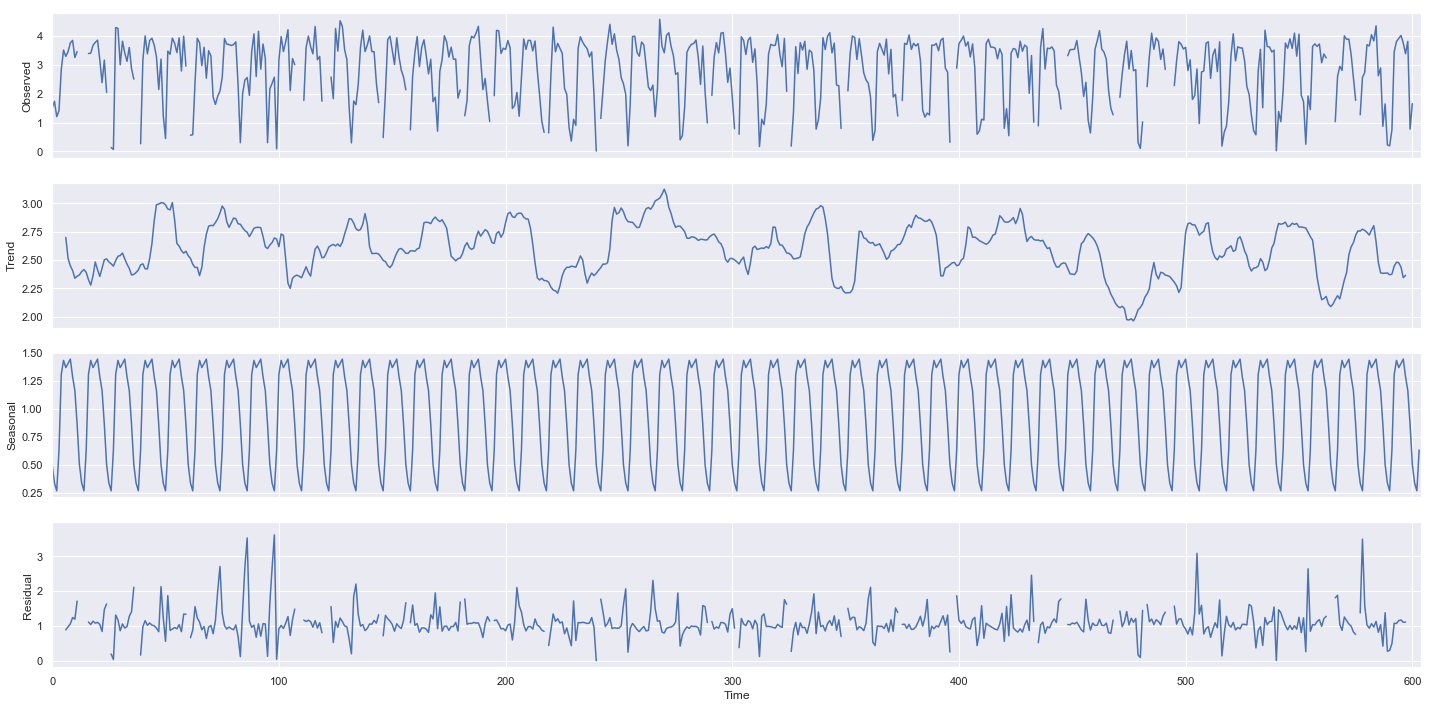

In [18]:
import seaborn as sns; sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose

#check datatype of index
none_negative_train_log = np.ma.array(train_log, mask=(train_log<=0))

decomposition = seasonal_decompose(none_negative_train_log, model='multiplicative', freq = 12)
residual = decomposition.resid
seasonal = decomposition.seasonal 
trend = decomposition.trend
fig = decomposition.plot()  
fig1=plt.gcf()
plt.show()
fig1.savefig('seasonal_decompose.png', dpi=200)

In [19]:
from statsmodels.tsa.stattools import acf, pacf

def plot_acf_pacf(timeseries):
    lag_acf = acf(timeseries, nlags=40)
    lag_pacf = pacf(timeseries, nlags=40, method = 'ols')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--', color = 'red')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--', color = 'green')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--', color = 'green')
    plt.title('Partial Autocorrelation Function')
    fig2=plt.gcf()
    fig2.savefig('Partial Autocorrelation Function.png', dpi=200)
    
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--', color = 'red')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--', color = 'green')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--', color = 'green')
    plt.title('Autocorrelation Function')
    fig3=plt.gcf()
    fig3.savefig('Autocorrelation Function.png', dpi=200)
    
    plt.tight_layout()

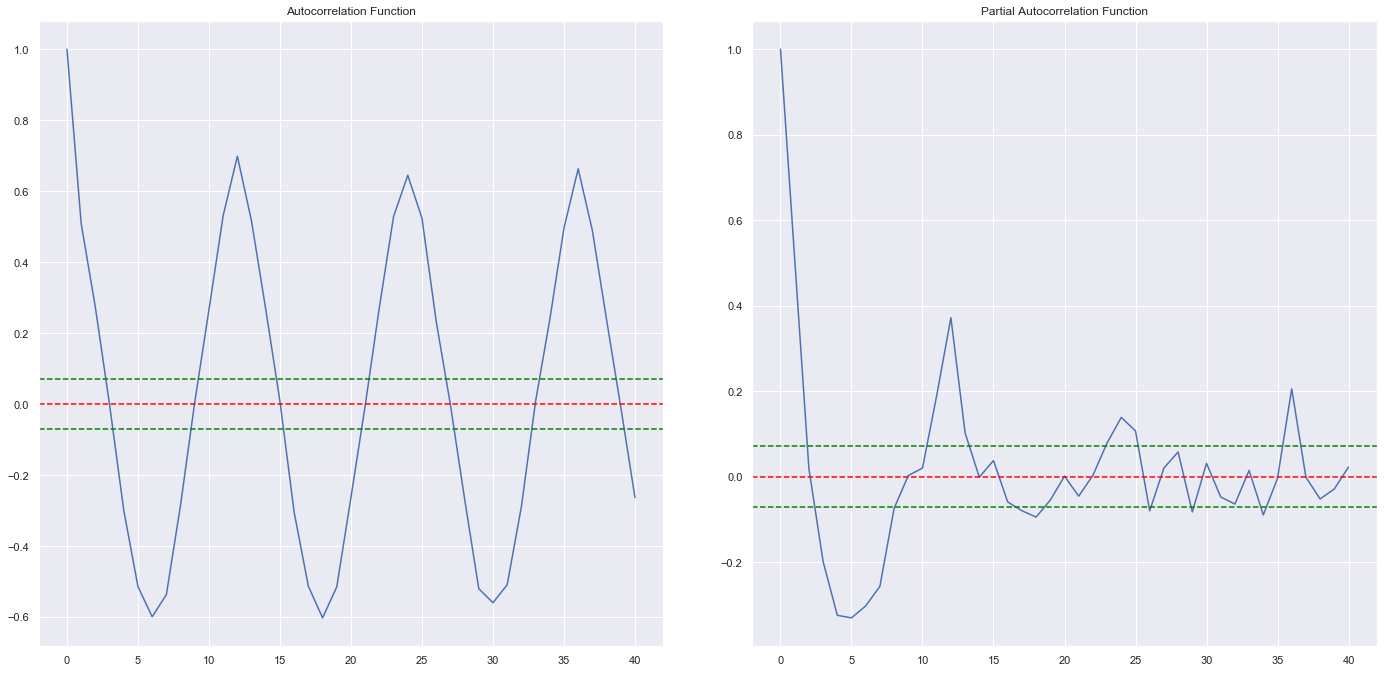

In [20]:
plot_acf_pacf(ts)

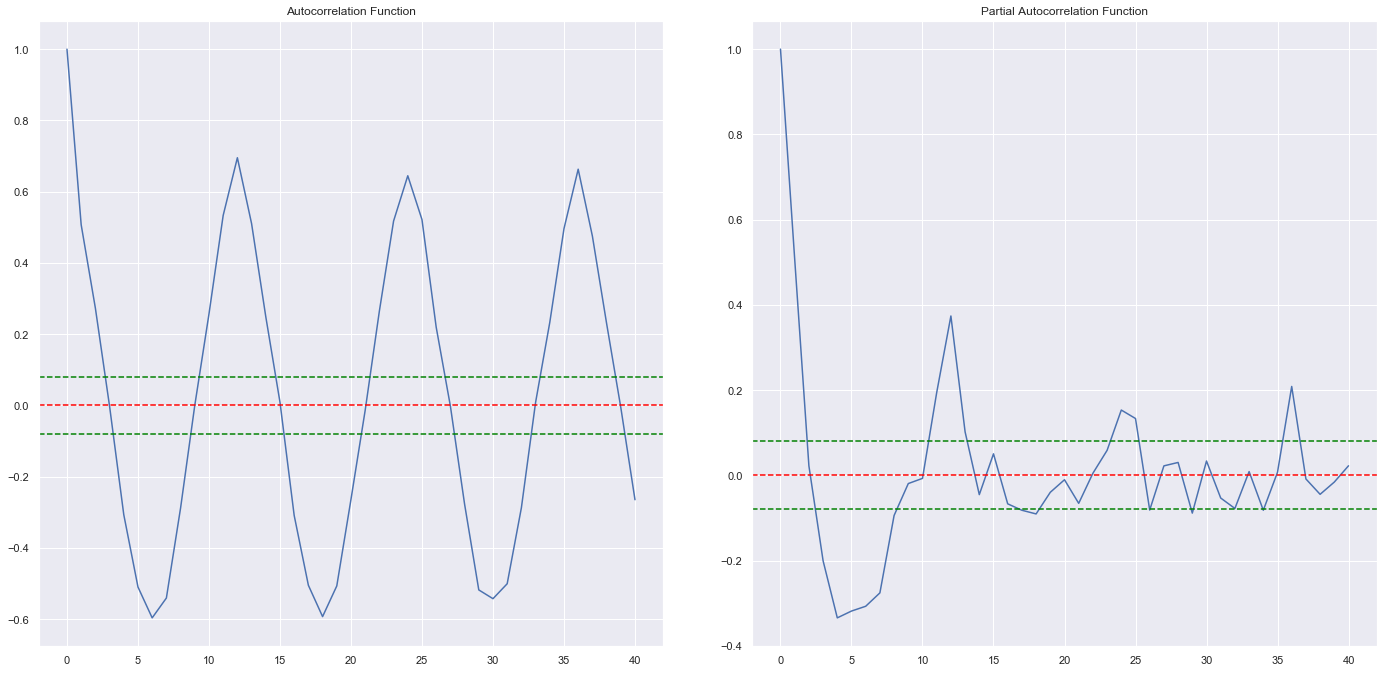

In [21]:
plot_acf_pacf(train)

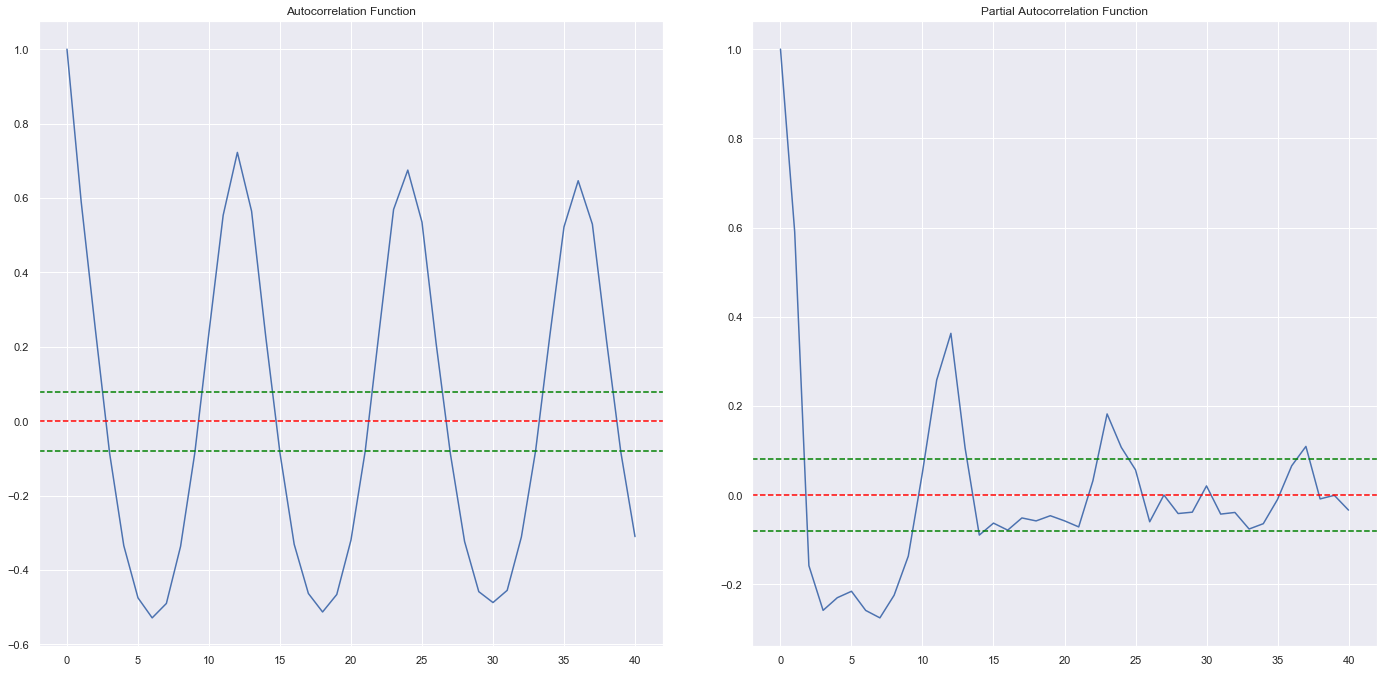

In [22]:
plot_acf_pacf(train_log)

{'fopt': 1.050947191787212, 'gopt': array([-1.33116851e-05,  2.68703060e-05,  1.39594114e-05,  2.61718647e-05,
        4.58832972e-07,  1.97595051e-05, -1.60158331e-05,  1.94163352e-05,
        3.62456731e-06,  1.60841118e-05,  1.87538873e-07]), 'fcalls': 672, 'warnflag': 0, 'converged': True, 'iterations': 48}


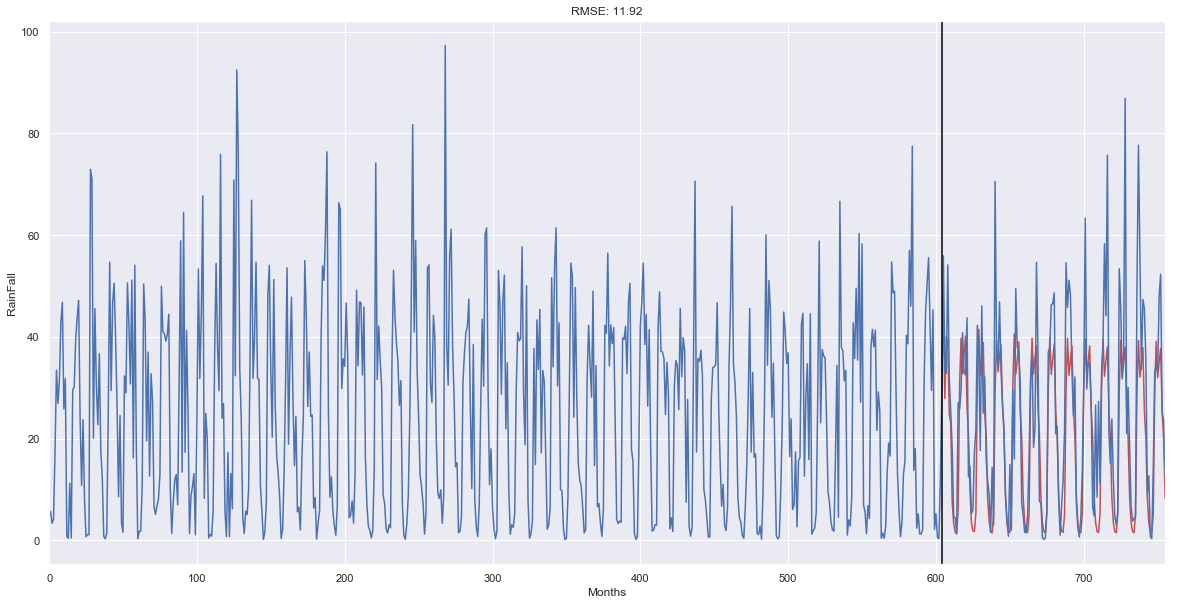

In [23]:
from statsmodels.tsa.statespace.sarimax  import SARIMAX
from sklearn.metrics import mean_squared_error
from IPython.display import display_html 
from math import sqrt

model = SARIMAX(train_log, order=(2, 1, 3),seasonal_order=(2,1,3,12) ,enforce_invertibility=False ,enforce_stationarity=False)
model_fit= model.fit(maxIter = 200, disp=False)
print(model_fit.mle_retvals)

K = len(test)
forecast = model_fit.forecast(K,dynamic=True)
forecast = np.exp(forecast)

plt.plot(forecast, 'r')
plt.plot(ts, 'b')
rms = sqrt(mean_squared_error(forecast,test))
plt.title('RMSE: %.2f'% rms)
plt.xlabel("Months")
plt.ylabel("RainFall")
plt.autoscale(enable=True, axis='x', tight = True)
plt.axvline(x=ts.index[num_of_rows],color='black')
#print(np.c_[forecast, test])
fig4=plt.gcf()
fig4.savefig('Model Performance.png', dpi=200)

In [24]:
print('RSS: %.4f'%sum((forecast - test)**2))

RSS: 21586.8674


In [25]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

resDiff = sm.tsa.arma_order_select_ic(train_log, max_ar=4, max_ma=4, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (4, 3) is the best.


In [26]:
resDiff

{'aic':              0            1            2            3            4
 0  2132.908229  1926.708877  1866.850675  1852.652356  1854.559327
 1  1876.555764  1870.193101  1911.675149  1834.786045  1801.226959
 2  1863.504351  1746.526601          NaN          NaN  4110.144938
 3  1824.571884  1720.182748  1602.148574  1595.731955          NaN
 4  1794.463486  1711.300089          NaN  1542.402146          NaN,
 'aic_min_order': (4, 3)}

In [27]:
indexed2 = indexed1.selectExpr("subDvn","cast(YEAR as int) YEAR", "cast(JAN as float) JAN", "cast(FEB as float) FEB", "cast(MAR as float) MAR", "cast(APR as float) APR", "cast(MAY as float) MAY" \
, "cast(JUN as float) JUN", "cast(JUL as float) JUL", "cast(AUG as float) AUG", "cast(SEP as float) SEP", "cast(OCT as float) OCT" \
, "cast(NOV as float) NOV",  "cast(DEC as float) DEC", "cast(ANNUAL as float) ANNUAL")
splits = indexed2.randomSplit([0.8,0.2])
df_train = splits[0]
df_test = splits[1]

In [28]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer

indexer = StringIndexer(inputCol='subDvn', outputCol='label')
vectorAssembler = VectorAssembler(inputCols=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'], outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

In [29]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(maxIter=5, regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[indexer, vectorAssembler,normalizer,lr])
model = pipeline.fit(df_train)
prediction = model.transform(df_train)
prediction.show()

+------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+--------------------+--------------------+--------------------+-----------+----------+
|subDvn|YEAR|  JAN|  FEB|  MAR|  APR|  MAY|  JUN|  JUL|  AUG|  SEP|  OCT|  NOV|  DEC|ANNUAL|label|            features|       features_norm|       rawPrediction|probability|prediction|
+------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+--------------------+--------------------+--------------------+-----------+----------+
|   0.0|1915| 45.0| 56.7| 33.3| 40.9|170.2|334.7|269.0|317.2|429.8|468.1|258.4|318.0|2741.3|  0.0|[45.0,56.70000076...|[0.01641556919150...|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|   0.0|1917|  8.0|  3.6|112.0|  4.5|295.9|301.1|394.8|437.4|471.8|238.1|108.3|236.9|2612.4|  0.0|[8.0,3.5999999046...|[0.00306231820716...|[Infinity,-Infinity]|  [1.0,0.0]|       0.0|
|   0.0|1918| 77.4|  6.9| 11.4| 10.7|729.3|710.8|200.9|455.4|303.3|227.0|36

In [30]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
eval.evaluate(prediction)

1.0

In [31]:
model = pipeline.fit(df_test)
prediction = model.transform(df_test)
eval.evaluate(prediction)

1.0

In [32]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(36).setSeed(1)
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler,kmeans])
model = pipeline.fit(indexed2)
wssse = model.stages[1].computeCost(vectorAssembler.transform(indexed2))
print(wssse)

1202067.248080286


In [33]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = '{0:.5f}'.format(value)
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [34]:
TestStationaryAdfuller(ts)

Test Statistic                    -6.15417
p-value                        7.43743e-08
#Lags Used                              18
Number of Observations Used            737
Critical Value (1%)               -3.43925
Critical Value (5%)               -2.86547
Critical Value (10%)              -2.56886
dtype: object
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


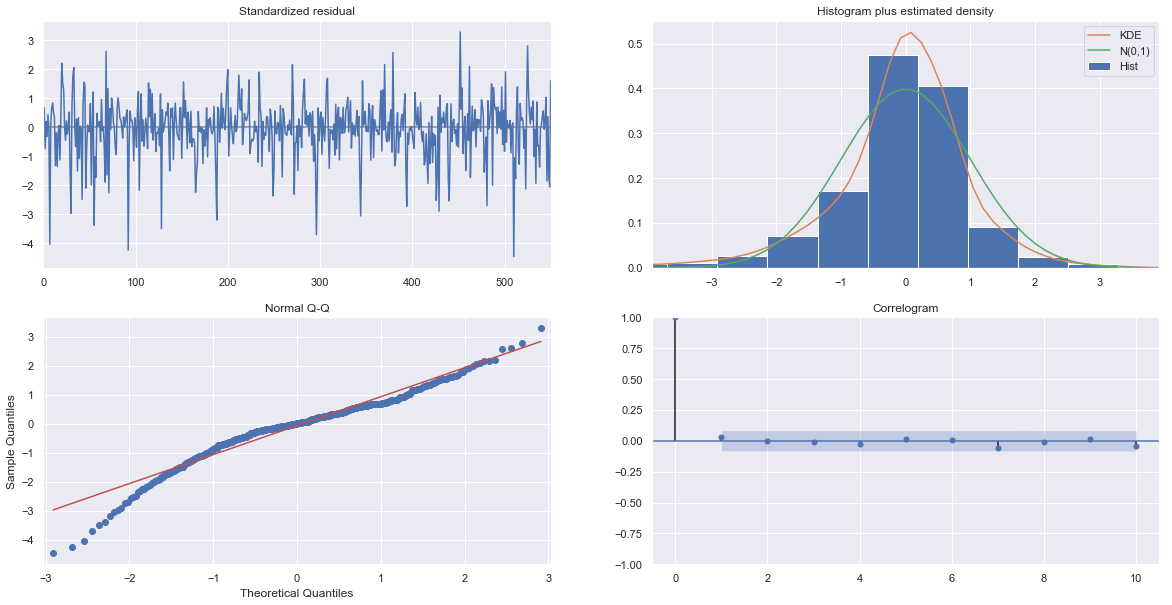

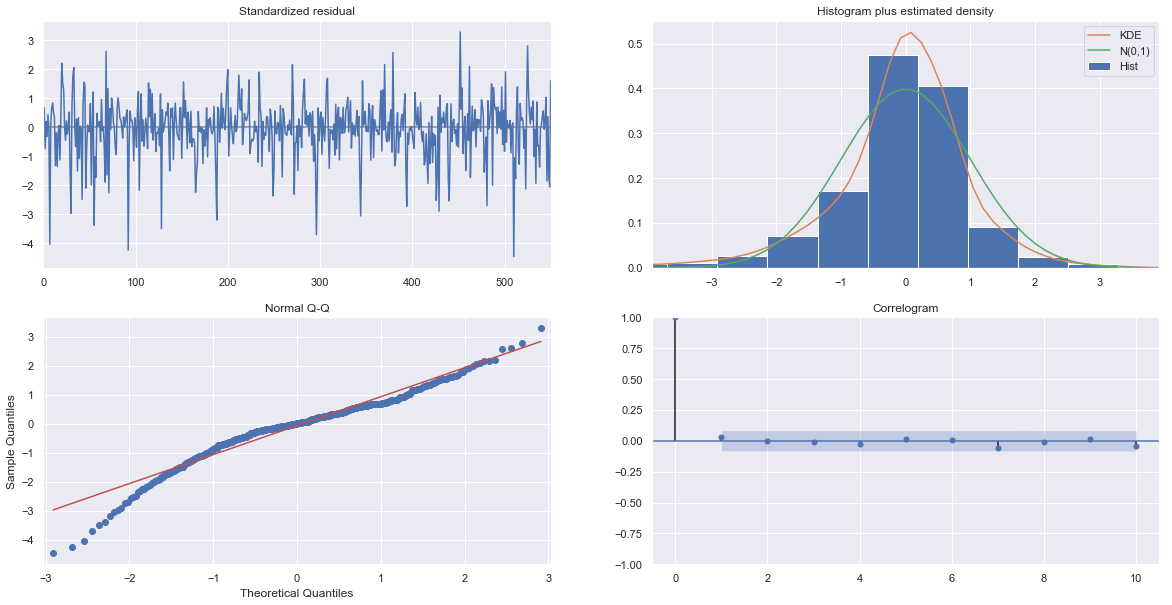

In [35]:
model_fit.plot_diagnostics()

In [104]:
from sklearn.impute import SimpleImputer 

si = SimpleImputer()
ts = si.fit_transform(annualrain2)
# count the number of NaN values in each column
print(np.isnan(annualrain2).sum())
annualrain2

fill_NaN = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_DF = pd.DataFrame(fill_NaN.fit_transform(annualrain2))
imputed_DF.columns = annualrain2.columns
imputed_DF.index = annualrain2.index
annualrain2 = imputed_DF
annualrain2

YEAR      0
Month     0
RainMM    0
dtype: int64


,YEAR,Month,RainMM
0,1915.0,1.0,45.000000
1,1917.0,1.0,8.000000
2,1918.0,1.0,77.400002
3,1920.0,1.0,122.300003
4,1922.0,1.0,245.300003
5,1927.0,1.0,3.000000
6,1928.0,1.0,50.900002
7,1929.0,1.0,74.199997
8,1930.0,1.0,87.400002
9,1933.0,1.0,4.500000


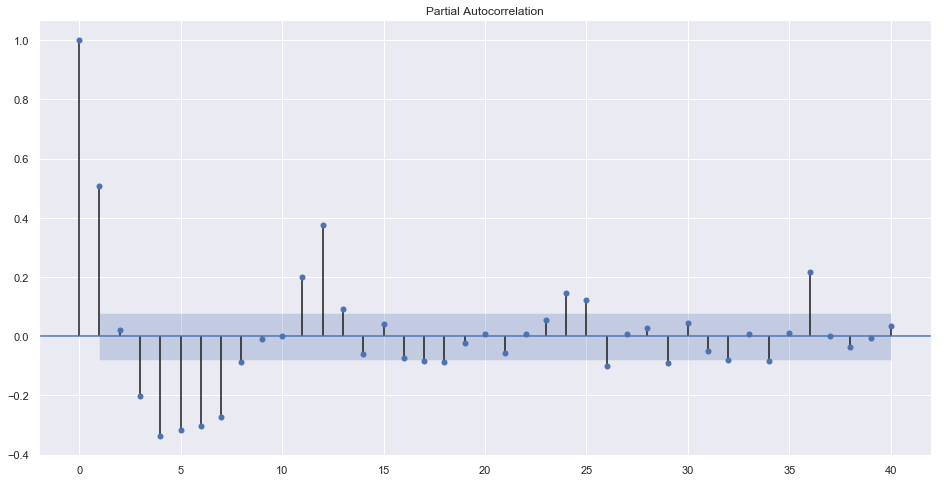

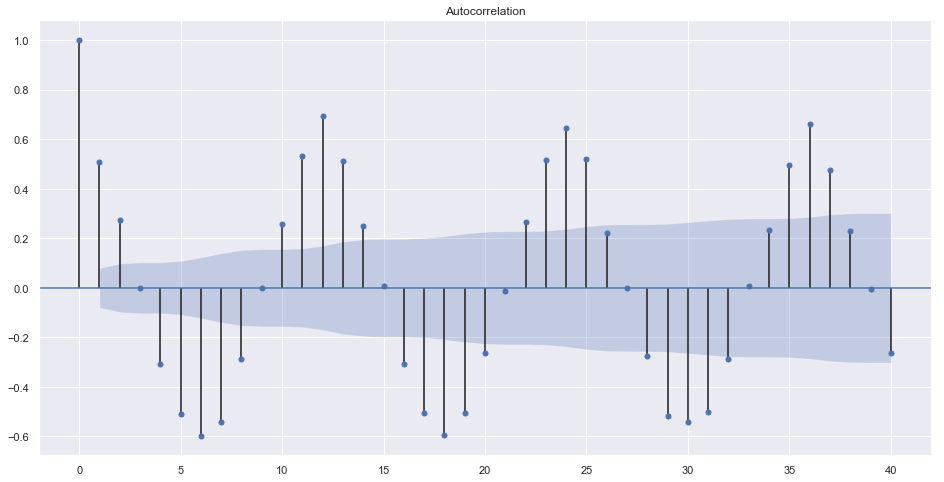

In [107]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
plot_pacf(train, lags=40)
plot_acf(train,lags=40)
pyplot.show()

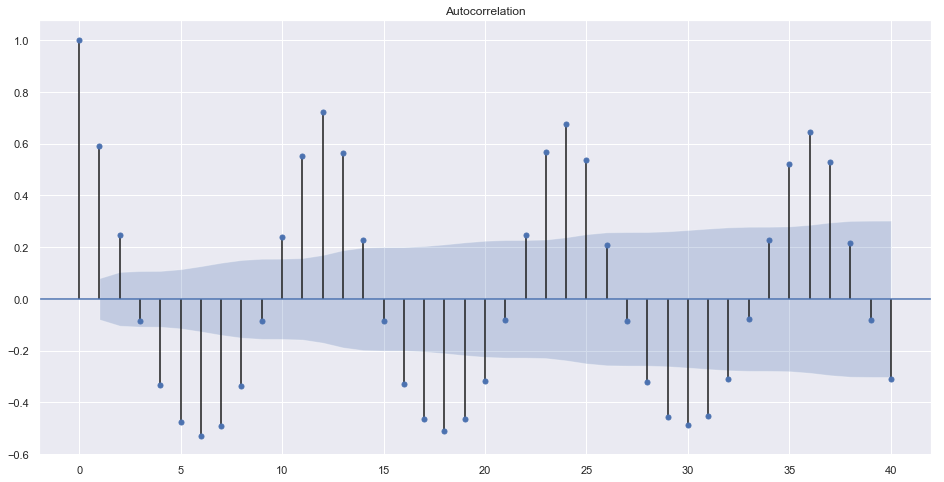

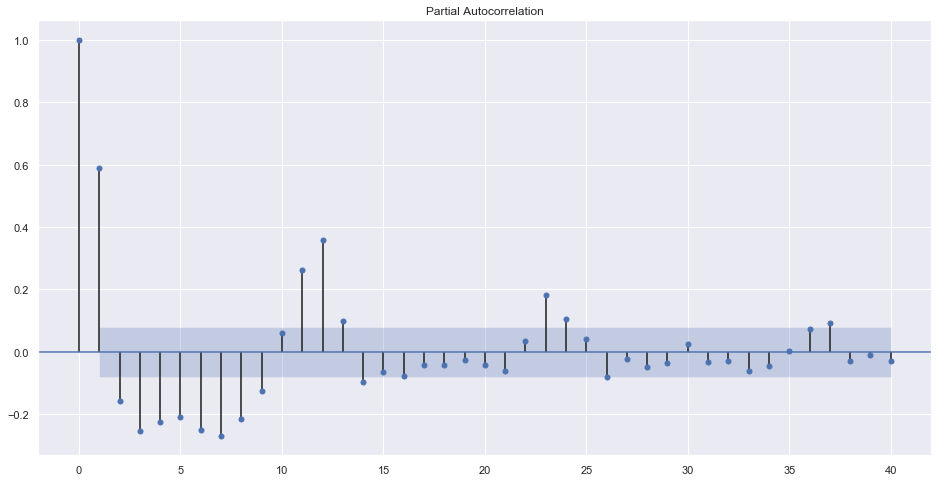

In [108]:
plot_acf(train_log,lags=40)
plot_pacf(train_log, lags=40)
pyplot.show()